In [48]:
import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json

import open_clip

import transformers
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

In [13]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
FILE_FABRITIUS_ICONOGRAPHIES_JSON = PARENT + os.getenv("FILE_FABRITIUS_ICONOGRAPHIES_JSON")

##

def fixPath(path):
    return path.replace(".././", "../")

def get_image_path_from_recordID(dataset, recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = dataset[
        dataset["recordID"] == recordID
    ]["low_res_filename"].values
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
    return merged_path

In [2]:
class ImageTextDataset(Dataset):
    def __init__(self, dataframe, preprocess, getImageFromRecordID):
        self.dataframe = dataframe
        self.preprocess = preprocess
        self.getImageFromRecordID = getImageFromRecordID

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        path = self.getImageFromRecordID(self.dataframe, row['recordID']) 
        image = Image.open(path)
        image = self.preprocess(image)  
        
        # Return image and caption (not used)
        return image, "empty"

In [14]:
FULL_DATASET = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)
# Remove rows with corrupted images
FULL_DATASET = FULL_DATASET[FULL_DATASET["recordID"] != 11546]
FULL_DATASET = FULL_DATASET[FULL_DATASET["recordID"] != 5262]
FULL_DATASET = FULL_DATASET.sample(frac=0.10).reset_index(drop=True)
FULL_DATASET

,recordLanguage,recordID,DatabaseId,LinkToVubis,objectWork.creatorDescription,objectWork.termClassification,objectWork.workID,objectWork.titleText,objectWork.objectWorkType,objectWork.measurementsDescription,...,objectWorkType_is_esquisse,objectWorkType_is_estampe,objectWorkType_is_grisaille,objectWorkType_is_photographie,objectWorkType_is_polyptyque,objectWorkType_is_retable,objectWorkType_is_sanguine,objectWorkType_is_triptyque,objectWorkType_is_ébauche,contains_desired_objectWorkType
0,fre,1107,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Emile Claus,peinture (Dept. Art Moderne),6827,"Coucher de soleil sur la Tamise, Londres",['tableau (toile)'],"[71.0, 92.0]",...,False,False,False,False,False,False,False,False,False,True
1,fre,5837,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Peeter Snijers,peinture (Dept. Art Ancien),6810,Le mois de mai (La constellation des Gémeaux),['tableau (toile)'],"[83.3, 66.8]",...,False,False,False,False,False,False,False,False,False,True
2,fre,1394,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Pellegrino Tibaldi (d'après),oeuvre sur papier (Dept. Art Ancien),10878,Saint Jean baptisant les foules,['dessin'],NaN,...,False,False,False,False,False,False,False,False,False,True
3,fre,7919,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Nicolaes Pietersz. Berchem,oeuvre sur papier (Dept. Art Ancien),4060 / 235,"Cavalier et bergers avec leurs animaux, dans u...",['dessin'],NaN,...,False,False,False,False,False,False,False,False,False,True
4,fre,8546,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Constantin Meunier,oeuvre sur papier (Dept. Art Moderne),10000 / 257,La chaudronnerie,['aquarelle'],NaN,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,fre,6233,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Gustave De Smet,peinture (Dept. Art Moderne),7967,Fermette,['tableau (toile)'],"[47.2, 58.5]",...,False,False,False,False,False,False,False,False,False,True
297,fre,2008,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Louis Gallait,peinture (Dept. Art Moderne),2717,La prise d'Antioche par les croisés,['tableau (toile)'],"[75.0, 133.5]",...,False,False,False,False,False,False,False,False,False,True
298,fre,7302,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Egbert van Drielst,oeuvre sur papier (Dept. Art Ancien),4060 / 1123,Bétail dans un chemin sous bois,['dessin'],NaN,...,False,False,False,False,False,False,False,False,False,True
299,fre,2471,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Jan Fyt,peinture (Dept. Art Ancien),2641,"Fleurs et fruits dans un paysage avec un ""Noli...",['tableau (toile)'],"[118.0, 197.0]",...,False,False,False,False,False,False,False,False,False,True


In [16]:
# Load the iconographies (json file)
with open(FILE_FABRITIUS_ICONOGRAPHIES_JSON, "r", encoding="utf-8") as f:
    ICONOGRAPHIES = json.load(f)
len(ICONOGRAPHIES)

3010

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
model_name = 'M-CLIP/XLM-Roberta-Large-Vit-B-16Plus'

# Load Model & Tokenizer
text_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(model_name)
text_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
text_model = text_model.to(device)
text_model.eval()
text_model.device

device(type='cuda', index=0)

In [8]:
openclip_model_name = "ViT-B-16-plus-240"
openclip_pretrained = "laion400m_e32"

image_model, _, image_preprocess = open_clip.create_model_and_transforms(openclip_model_name, pretrained=openclip_pretrained)
#self.openclip_tokenizer = open_clip.get_tokenizer(openclip_model_name)
image_model = image_model.to(device)
image_model.eval()
print("CLIP model loaded")

CLIP model loaded


In [52]:
checkpoint = "google/owlv2-base-patch16-ensemble"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection", device=device)

Device set to use cuda


In [9]:
try:
    text_model.forward("test", text_tokenizer, device=device)
    print("GOOD: Model has been modified to allow for device in forward")
except:
    raise Exception("Model has not been modified to allow for device in forward !")

GOOD: Model has been modified to allow for device in forward


In [18]:
# 0) Load data
dataset = ImageTextDataset(FULL_DATASET, image_preprocess, get_image_path_from_recordID)
dataloader = DataLoader(dataset, batch_size=2, num_workers=0)
print(len(dataloader), "batches")

151 batches


In [24]:
# 1) Compute image embeddings
image_embeddings = torch.zeros(0, 640).to(device)
for images, _ in tqdm(dataloader):
    images = images.to(device)
    with torch.no_grad():
        image_features = image_model.encode_image(images)
    image_embeddings = torch.cat((image_embeddings, image_features), dim=0)    

# Normalize embeddings
image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
print("OK: Image embeddings normalized", image_embeddings.shape)

100%|██████████| 151/151 [00:05<00:00, 26.10it/s]

OK: Image embeddings normalized torch.Size([301, 640])


In [26]:
def embed_mQuery(mQuery, text_model, text_tokenizer, device):
    text_model.eval()
    with torch.no_grad():
        query_embedding = torch.zeros((1, 640)).to(device)
        for i, query in enumerate(mQuery):
            term, weight = query
            part = weight * text_model.forward(term, text_tokenizer, device=device) # Note: add device parameter to forward manually
            query_embedding += part

    # Normalize
    query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)

    return query_embedding

In [43]:
queries = [
    {
        "type": "object",
        "term": "personne",
        "mQuery": [
            ("An art piece with a person", 1.0),
        ]
    }
]
# Test
query_embedding = embed_mQuery(queries[0]["mQuery"], text_model, text_tokenizer, device)
query_embedding.shape

torch.Size([1, 640])

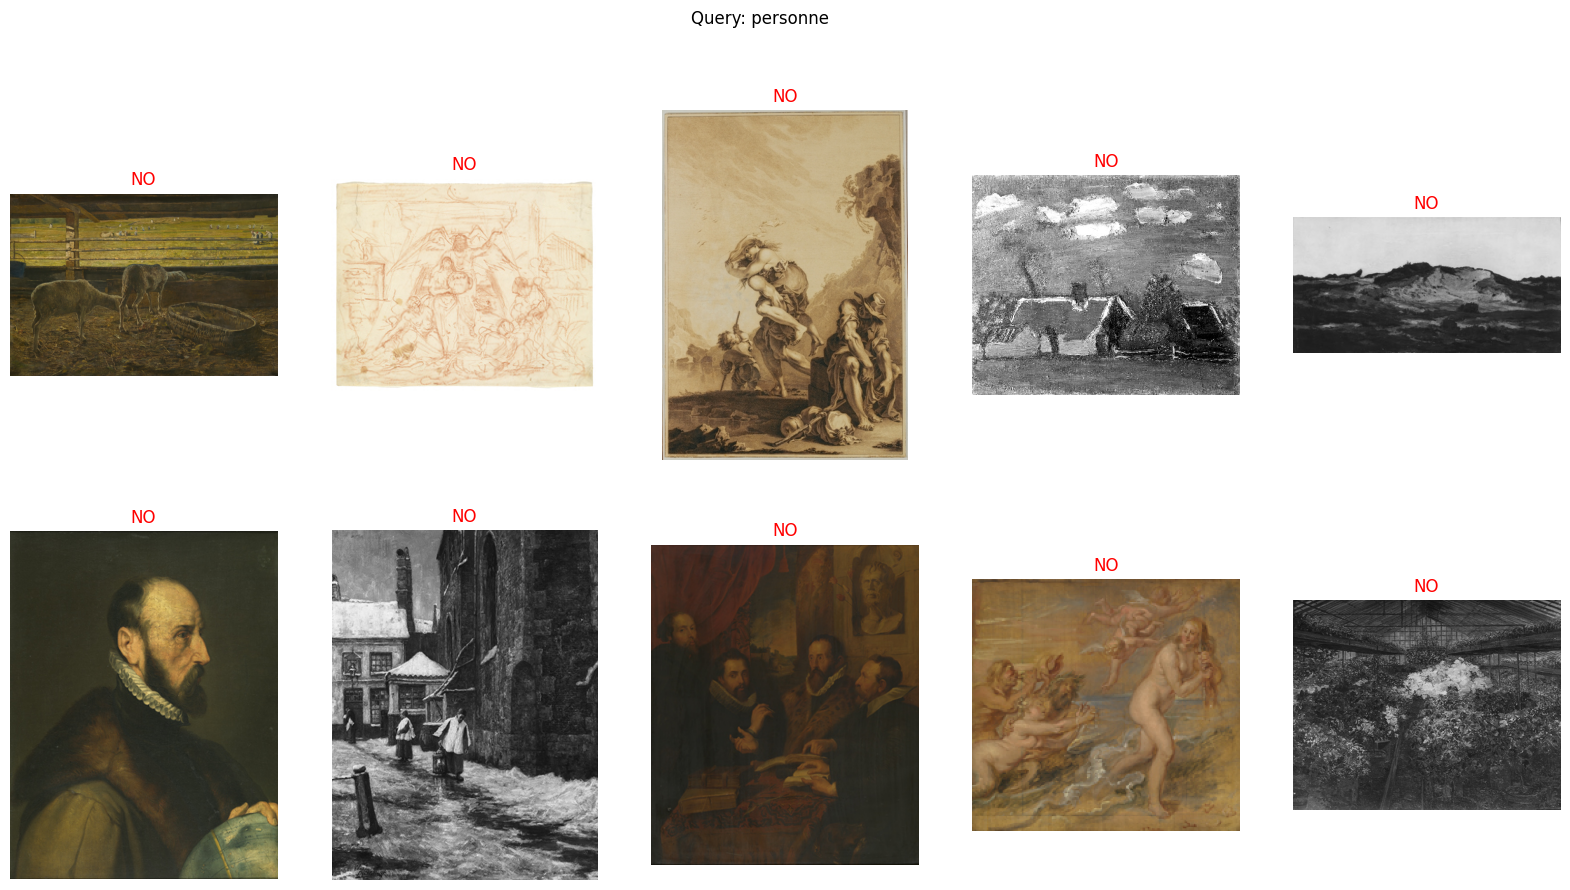

In [56]:
# Sample 10 random recordIDs from the dataset
def plotCandidates(candidates, query, answers=None):
    if answers is None:
        answers = [False] * len(candidates)

    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    for i, ax in enumerate(axs.flat):
        recordID = candidates.iloc[i]["recordID"]
        path = get_image_path_from_recordID(candidates, recordID)
        image = Image.open(path)
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        # Add a red border if the answer is NO
        ax.set_title("YES" if answers[i] else "NO", color="green" if answers[i] else "red")
    plt.suptitle(f"Query: {query['term']}")
    plt.show()

# Set seed
candidates = FULL_DATASET.sample(10, random_state=0)
plotCandidates(candidates, queries[0])

In [78]:
def getObjectsFreq(iconography):
    frequency = {}
    def visit(node):
        value = node["value"]
        children = node["children"]

        isGroup = value == "<group>"
        isRoot = value == "root"

        if not isGroup and not isRoot:
            if value not in frequency:
                frequency[value] = 0
            frequency[value] += 1

        for child in children:
            visit(child)

    for recordID in iconography:
        visit(iconography[recordID])

    # Divide by the number of records
    for key in frequency:
        frequency[key] = frequency[key] / len(iconography)

    return frequency

In [87]:
from scipy.sparse import lil_matrix 
"""
Let's assume that each object has a specific threshold for the cosine similarity.
Using the iconography, we can estimate it !
"""
counts = getObjectsFreq(ICONOGRAPHIES)
print(len(counts), "unique objects")

# Order the objects by frequency
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

MIN_FREQ = 0.01 # Minimum frequency to consider an object

counts_filtered = {k: v for k, v in counts.items() if v > MIN_FREQ}
print(len(counts_filtered), "objects with frequency >=", MIN_FREQ)

counts_filtered_objects = list(counts_filtered.keys())
print(counts_filtered_objects)

1328 unique objects
153 objects with frequency >= 0.01
['figure', 'homme', 'barbe', 'groupe de figures', 'chapeau', 'femme', 'assis', 'intérieur', 'tableau', 'toile', 'table', 'livre', 'fleur', 'en buste', 'de profil', 'foule', 'soldat', 'casque', 'arme', 'lance', 'animal', 'cheval', 'chien', 'coiffure', 'couronne', 'nu', 'en pied', 'vêtement', 'robe', 'à mi-corps', 'couvre-chef', 'habit', 'jeune fille', 'enfant', 'fillette', 'coiffe', 'église', 'chandelle', 'paysage', 'village', 'maison', 'arbre', 'représentation animalière', 'tissu', 'bijou', 'bateau', 'bateau à voiles', 'pont', 'rocher', 'rive', 'nourrisson', 'fourrure', 'chaussure', 'lit', 'cruche', 'architecture', 'fenêtre', 'pavement', 'bâtiment', 'escalier', 'colonne', 'sculpture', 'statue', 'fond de paysage', 'ville', 'vieux', 'agenouillé', 'colline', 'mouton', 'être imaginaire', 'aile', 'instrument de musique', 'voile', 'marine', 'mer', 'bâton', 'croix', 'drapeau', 'outil', 'cheminée', 'épée', 'main', 'panier', 'façade', 'cost

In [100]:
# Sparse matrix: recordID x object
object_presence_per_recordID = lil_matrix((len(FULL_DATASET), len(counts_filtered_objects)), dtype=bool)
print(object_presence_per_recordID.shape)

for recordIndex, row in FULL_DATASET.iterrows():
    recordID = row["recordID"]
    iconography = ICONOGRAPHIES[str(recordID)]
    def visit(node):
        value = node["value"]
        children = node["children"]

        isInFiltered = value in counts_filtered_objects

        if isInFiltered:
            objectIndex = list(counts_filtered_objects).index(value)
            try:
                object_presence_per_recordID[recordIndex, objectIndex] = True
            except:
                print(recordIndex, objectIndex)
                raise Exception("Error")

        for child in children:
            visit(child)

    visit(iconography)

number_of_non_zero_elements = object_presence_per_recordID.count_nonzero()
print(number_of_non_zero_elements, "non-zero elements out of ", object_presence_per_recordID.shape[0] * object_presence_per_recordID.shape[1])

(301, 153)
2153 non-zero elements out of  46053


In [ ]:
for objectIndex, object in enumerate(counts_filtered_objects):

    object_embedding = text_model.forward(f"An image with {object}", text_tokenizer, device=device)
    object_embedding = object_embedding / object_embedding.norm(dim=-1, keepdim=True)

    # Compute cosine similarity
    similarities = cosine_similarity(object_embedding.cpu().numpy(), image_embeddings.cpu().numpy())
    
    # Find the threshold needed to get the correct predictions
    pass


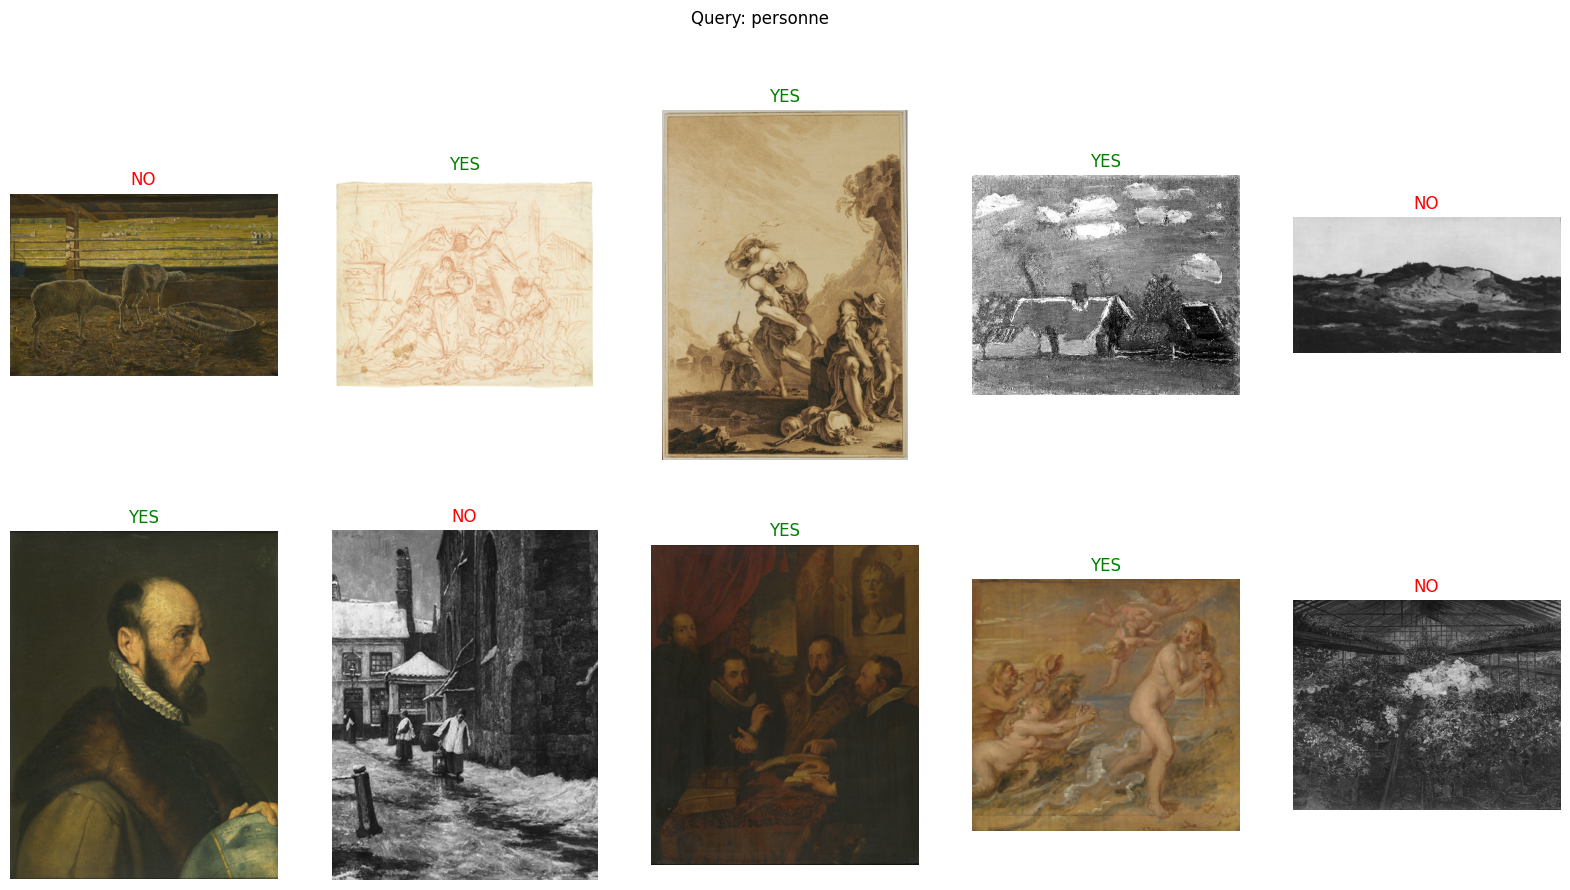

In [60]:
def get_answers(candidates, query):
    # Get embeddings for each candidate
    candidatesIndexes = candidates.index
    candidate_embeddings = image_embeddings[candidatesIndexes]

    # Get logits for each candidate
    query_embedding = embed_mQuery(query["mQuery"], text_model, text_tokenizer, device)
    similarities = cosine_similarity(query_embedding.cpu(), candidate_embeddings.cpu())
    similarities = similarities.squeeze()

    # Threshold
    threshold = 0.15
    answers = similarities > threshold
    return answers

answers = get_answers(candidates, queries[0])
plotCandidates(candidates, queries[0], answers)